## Initial Steps for Working with GRIB Dataset in Python

### Step 1: Install Required Libraries
You will need pygrib, xarray, numpy, pandas, and matplotlib.
Use the following command to install them:
!pip install pygrib xarray numpy pandas matplotlib

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Step 2: Load and Explore the GRIB Data

In [2]:
# Load the GRIB dataset
data = xr.open_dataset('./spain_may2sept.grib', engine="cfgrib")

# Print available coordinates
print("Coordinates of the dataset:")
print(data.coords)

# Optionally, print specific coordinate values
print("\nLatitude values:")
print(data["latitude"].values)

print("\nLongitude values:")
print(data["longitude"].values)

# If the dataset has time:
if "time" in data.coords:
    print("\nTime values:")
    print(data["time"].values)
    
print(data.data_vars)

skipping variable: paramId==235033 shortName='msshf'
Traceback (most recent call last):
  File "c:\Users\Ana\anaconda3\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\Ana\anaconda3\Lib\site-packages\cfgrib\dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1143849600, 1143892800, 1143936000, ..., 1727611200, 1727654400,
       1727697600])) new_value=Variable(dimensions=('time',), data=array([1143828000, 1143871200, 1143914400, ..., 1727589600, 1727632800,
       1727676000]))
skipping variable: paramId==147 shortName='slhf'
Traceback (most recent call last):
  File "c:\Users\Ana\anaconda3\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\Ana\anaconda3\Lib\site-packages\cfgrib\d

Coordinates of the dataset:
Coordinates:
    number               int32 ...
  * time                 (time) datetime64[ns] 2006-04-01 ... 2024-09-30T12:0...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * latitude             (latitude) float64 44.0 43.75 43.5 ... 36.5 36.25 36.0
  * longitude            (longitude) float64 -10.0 -9.75 -9.5 ... 3.5 3.75 4.0
    valid_time           (time) datetime64[ns] ...
    depthBelowLandLayer  float64 ...

Latitude values:
[44.   43.75 43.5  43.25 43.   42.75 42.5  42.25 42.   41.75 41.5  41.25
 41.   40.75 40.5  40.25 40.   39.75 39.5  39.25 39.   38.75 38.5  38.25
 38.   37.75 37.5  37.25 37.   36.75 36.5  36.25 36.  ]

Longitude values:
[-10.    -9.75  -9.5   -9.25  -9.    -8.75  -8.5   -8.25  -8.    -7.75
  -7.5   -7.25  -7.    -6.75  -6.5   -6.25  -6.    -5.75  -5.5   -5.25
  -5.    -4.75  -4.5   -4.25  -4.    -3.75  -3.5   -3.25  -3.    -2.75
  -2.5   -2.25  -2.    -1.75  -1.5   -1.25  -1.    -0.75  -0.5

## Generate labels for hot days

In [3]:
data_region = data.sel(
    latitude=slice(43, 38),  # From 43°N to 38°N (descending order)
    longitude=slice(-8, -1)  # From 8°W to 1°W (ascending order)
)
# Step 1: Restrict the dataset to May–August
data_summer = data_region.sel(time=data["time"].dt.month.isin([5, 6, 7, 8, 9]))

# Step 2: Extract temperature data (e.g., variable "t2m") for the summer months
temperature_summer = data_summer["t2m"]
# Step 3: Filter temperature measurements at 12:00 within summer months
# Step 3: Filter temperature measurements at 12:00 within summer months
temp_summer_12 = temperature_summer.sel(time=temperature_summer["time"].dt.hour == 12)

# Convert the time to "day" in datetime format with time set to 00:00:00
temp_summer_12 = temp_summer_12.assign_coords(day=temp_summer_12["time"].dt.floor("D"))

# Use "day" as the main dimension
temp_summer_12 = temp_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)

# Step 4: Extract July–August temperatures for percentile calculation
temp_july_aug = temp_summer_12.sel(day=temp_summer_12["day"].dt.month.isin([7, 8]))


# Step 5: Compute the 95th percentile for each location in July–August
percentile_95 = temp_july_aug.quantile(0.95, dim="day")

# Step 6: Label hot days (May–August) based on the 95th percentile
hot_days = temp_summer_12 > percentile_95

# Step 7: Add the "hot_day" label to the summer dataset
data_summer_labeled = data_summer.assign(hot_day=hot_days)

# Optional: Save the labeled dataset for further analysis
# data_summer_labeled.to_netcdf("labeled_summer_dataset.nc")

# Step 8: Verify the results
# print("Summer Dataset with Hot Day Labels:")
# print(data_summer_labeled.where(data_summer_labeled["hot_day"], drop=True))



## Aggregate all measurements of one day under one timestamp

In [4]:
data_summer_00 = data_summer.sel(time=data_summer["time"].dt.hour == 0)
data_summer_12 = data_summer.sel(time=data_summer["time"].dt.hour == 12)

data_summer_00 = data_summer_00.assign_coords(day=data_summer_00["time"].dt.floor("D"))
data_summer_12 = data_summer_12.assign_coords(day=data_summer_12["time"].dt.floor("D"))

data_summer_00 = data_summer_00.swap_dims({"time": "day"}).reset_coords("time", drop=True)
data_summer_12 = data_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)


# Rename variables in each dataset to include their time suffix
data_summer_00 = data_summer_00.rename({var: f"{var}_00" for var in data_summer_00.data_vars})
data_summer_12 = data_summer_12.rename({var: f"{var}_12" for var in data_summer_12.data_vars})
data_summer_00 = data_summer_00.drop_vars("valid_time", errors="ignore")
data_summer_12 = data_summer_12.drop_vars("valid_time", errors="ignore")

# Merge the renamed datasets
data_summer_merged = xr.merge([data_summer_00, data_summer_12])


In [5]:
# Recalculate the percentile with a lower threshold
percentile_95 = temp_july_aug.quantile(0.95, dim="day")
print("95th Percentile Temperature Values:")
print(percentile_95-273)

95th Percentile Temperature Values:
<xarray.DataArray 't2m' (latitude: 21, longitude: 29)>
array([[27.5572876 , 27.87758789, 27.97233887, 28.19266357, 27.68026123,
        27.32561035, 26.5927002 , 26.18048096, 25.74979248, 26.54486084,
        27.04223633, 27.00927734, 26.13225098, 26.30419922, 26.8317627 ,
        28.80769043, 29.26304932, 29.04807129, 30.08210449, 30.35366211,
        30.30133057, 30.58551025, 29.90827637, 29.87215576, 29.4390625 ,
        29.8085083 , 30.48804932, 30.46975098, 29.27783203],
       [28.48967285, 28.87312012, 29.31704102, 28.87319336, 28.87126465,
        28.95294189, 28.75070801, 28.32772217, 28.17265625, 29.48787842,
        30.04727783, 29.56262207, 28.8020752 , 28.99291992, 29.43897705,
        30.58569336, 30.51279297, 30.67890625, 31.7723877 , 31.82441406,
        31.68465576, 31.40041504, 31.4696167 , 31.14534912, 31.63909912,
        31.99084473, 31.91234131, 31.39389648, 30.24213867],
       [29.38776855, 29.41948242, 29.22969971, 29.4793335

In [6]:
# Count the number of hot days (True values) in the "hot_day" field
num_hot_days = data_summer_labeled["hot_day"].sum().item()

print(f"Total number of hot days: {num_hot_days}")

# Count the number of hot days (True values) in the "hot_day" field
num_days = data_summer_labeled.dims["day"]
print(f"Total number of days: {num_days}")

# Sum the count of non-NaN values in "t2m" across time, latitude, and longitude
num_data_points = data_summer_labeled["t2m"].notnull().sum().item()
print(f"Total number of data points: {num_data_points}")



Total number of hot days: 44517
Total number of days: 2907
Total number of data points: 3540726


In [7]:
print("Temp Summer Dimensions:", temp_summer_12.shape)
print("Percentile 95 Shape:", percentile_95.shape)
print("Hot Days Shape:", hot_days.shape)
variable_names = list(data.data_vars)
print("Variable names:", variable_names)


Temp Summer Dimensions: (2907, 21, 29)
Percentile 95 Shape: (21, 29)
Hot Days Shape: (2907, 21, 29)
Variable names: ['u10', 'v10', 'd2m', 't2m', 'msl', 'sp', 'skt', 'tcc', 'swvl1', 'blh', 'lsm', 'tcwv']


## Calculating the number of 3 day streaks for each location to check if labeling is plausible

Distinct Three-Day Streaks per Location:
<xarray.DataArray 't2m' (latitude: 21, longitude: 29)>
array([[ 7,  6,  7,  7,  6,  5,  6,  5,  4,  7,  7,  7,  7,  7,  6,  5,
         5,  6,  5,  4,  6,  5,  6,  6,  5,  4,  5,  6,  6],
       [ 6,  7,  7,  7,  6,  7,  8,  8,  8, 10,  9, 10, 10,  9,  6,  7,
         6,  4,  5,  5,  4,  6,  7,  7,  8,  9,  9,  7,  8],
       [ 6,  6,  7,  6,  6, 10,  8,  8,  9,  9,  8,  9, 10, 10,  6,  6,
         6,  7,  6,  4,  3,  4,  4,  7,  7,  8,  7,  8,  8],
       [ 5,  5,  5,  5,  6,  7,  7,  7,  9,  9,  9,  9,  8,  8,  8,  7,
         7,  8,  7,  6,  4,  6,  7,  8,  7,  8,  8,  8, 10],
       [ 6,  6,  6,  6,  7,  7,  7,  9,  9,  9,  9,  8,  8,  8,  9,  7,
         7,  8,  8,  8,  9,  7,  8,  7,  7,  7,  8,  8,  8],
       [ 5,  6,  5,  8,  8,  9, 10,  8,  8,  9,  9,  7,  8,  8,  8,  8,
         9,  9,  9,  7,  7,  6,  7,  9,  9,  9,  7,  7,  7],
       [ 5,  7,  7,  9,  8,  8,  8,  7,  7,  7,  8,  7,  7,  9,  9,  9,
         9,  7,  7,  7,  7,  7,  8

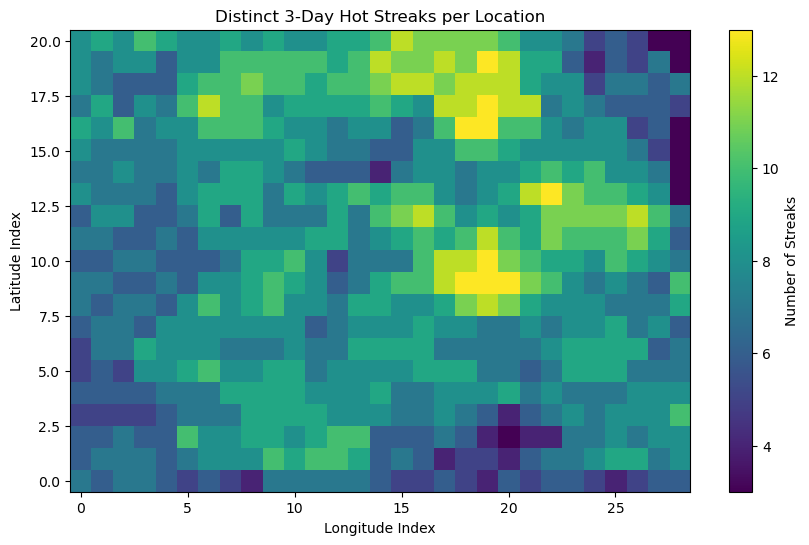

In [8]:
# deleting variables to free memory
del data, data_region, data_summer, temperature_summer, temp_summer_12, temp_july_aug, data_summer_labeled, data_summer_00, data_summer_12


# Step 1: Verify hot days array (already computed)
# print("Hot Days Array (Summary):")
# print(hot_days)

# Step 2: Apply a rolling window to compute streaks
streaks_rolling = (
    hot_days.rolling(day=3, center=False)   # Rolling 3-day window
    .construct("window_dim")                # Create a dimension for the rolling window
    .reduce(np.all, dim="window_dim")       # Check if all values in the window are True
)

# Step 3: Replace NaN values (from rolling) with 0
streaks_rolling_filled = streaks_rolling.fillna(0).astype(int)

# Verify rolling streaks
# print("Rolling Streaks (3-Day):")
# print(streaks_rolling_filled)

# Step 4: Count the number of streaks per location
def count_distinct_streaks(array):
    diff = np.diff(array, axis=0)
    streak_starts = (diff == 1).sum(axis=0)  # Count where a streak begins
    return streak_starts

distinct_streaks = xr.apply_ufunc(
    count_distinct_streaks,
    streaks_rolling_filled,
    input_core_dims=[["day"]],
    vectorize=True
)

# Step 5: Print results
print("Distinct Three-Day Streaks per Location:")
print(distinct_streaks)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Distinct 3-Day Hot Streaks per Location")
plt.imshow(distinct_streaks, origin="lower", aspect="auto")
plt.colorbar(label="Number of Streaks")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()


## Creating Target labels for each day (if the next 7 days contain at least 3 hot days)

In [9]:
# Define the rolling window size
window_size = 7

# Step 1: Restrict hot_days to May–July + first days of August
hot_days_limited = hot_days.sel(
    day=hot_days["day"].dt.month.isin([5, 6, 7]) |
         ((hot_days["day"].dt.month == 8) & (hot_days["day"].dt.day <= window_size))
)

# Count the number of hot days in each rolling window
hot_days_rolling = (
    hot_days.rolling(day=window_size, center=False)
    .construct("window_dim")
    .reduce(np.sum, dim="window_dim")
)

# Create labels: 1 if 3 or more hot days, 0 otherwise
labels_next_7_days = (hot_days_rolling >= 3).astype(int)

# Align the labels with the dataset (shift back by window_size - 1)
labels_next_7_days = labels_next_7_days.shift(day=-(window_size - 1))
# Does this makes sense?????

# Drop NaN values (caused by shifting)
labels_next_7_days = labels_next_7_days.dropna("day")

# Debug: Inspect the rolling sum
print("Rolling sum of hot days over 7-day window:")
print(hot_days_rolling)

# Debug: Inspect the labels before and after shifting
print("Labels before shifting (aligned with future interval):")
print((hot_days_rolling >= 3).astype(int))

print("Labels after shifting (aligned with current day):")
print(labels_next_7_days)

del hot_days, streaks_rolling, streaks_rolling_filled, distinct_streaks, hot_days_limited

Rolling sum of hot days over 7-day window:
<xarray.DataArray 't2m' (day: 2907, latitude: 21, longitude: 29)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ...,

In [10]:
from pympler import muppy, summary
# Filter global variables for numpy arrays and xarray datasets
arrays_and_datasets = {
    name: type(value).__name__
    for name, value in globals().items()
    if type(value).__name__ in ["ndarray", "Dataset", "DataArray"]
}

# Print the results
print(f"{'Variable':<20}{'Type':<20}")
print("=" * 40)
for name, var_type in arrays_and_datasets.items():
    print(f"{name:<20}{var_type:<20}")

# Collect all objects in memory
all_objects = muppy.get_objects()

# Summarize memory usage by type
summary.print_(summary.summarize(all_objects))

Variable            Type                
percentile_95       DataArray           
data_summer_merged  Dataset             
hot_days_rolling    DataArray           
labels_next_7_days  DataArray           
                                     types |   # objects |   total size
========================================== | =========== | ============
                                     tuple |      298817 |     28.48 MB
                                       str |      142864 |     22.52 MB
                                      code |       44650 |     17.46 MB
                                      dict |       36406 |     14.75 MB
                             numpy.ndarray |         164 |     14.14 MB
                                      list |       96819 |     10.01 MB
                                      type |        5829 |      7.17 MB
                                       int |      220106 |      6.23 MB
                                       set |        1902 |      1.42 MB
   

## Stacking data of 30 days onto each other and adding labels

In [11]:
print(data_summer_merged.coords)
#print("Rolling Chunk Days:")
#print(rolling_chunk["day"].values)

#print("\nLabels Next 7 Days:")
#print(labels_next_7_days["day"].values)


Coordinates:
    number               int32 0
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
  * latitude             (latitude) float64 43.0 42.75 42.5 ... 38.5 38.25 38.0
  * longitude            (longitude) float64 -8.0 -7.75 -7.5 ... -1.5 -1.25 -1.0
    depthBelowLandLayer  float64 0.0
  * day                  (day) datetime64[ns] 2006-05-01 ... 2024-09-30


In [12]:
import torch
import os
import numpy as np

# Extract unique years from the 'day' coordinate
years = np.unique(data_summer_merged["day"].dt.year)
feature_window_size = 30
percentile_95_stacked = percentile_95.stack(location=("latitude", "longitude"))

# Directory for saving temporary results
processed_dir = "temp_features_by_year"
os.makedirs(processed_dir, exist_ok=True)

for year in years:
    # Select data for the current year
    yearly_data = data_summer_merged.sel(
        day=(data_summer_merged["day"].dt.year == year) &
             (data_summer_merged["day"].dt.month.isin([5, 6, 7, 8]))
    )
    # Create rolling windows
    rolling_chunk = (
        yearly_data.rolling(day=feature_window_size, center=False)
        .construct("feature_dim")
        .dropna("day")
    )
    
    # Align features with labels
    yearly_labels = labels_next_7_days.sel(day=rolling_chunk["day"])
    rolling_chunk, yearly_labels = xr.align(rolling_chunk, yearly_labels, join="inner")

    # Extract and flatten features
    stacked_features = rolling_chunk.stack(location=("latitude", "longitude"))
    flattened_features = stacked_features.to_array(dim="variables").stack(
        features=("variables", "feature_dim")
    ).transpose("day", "location", "features")
    X = flattened_features.values.reshape(flattened_features.shape[0] * flattened_features.shape[1], -1)

    # Add percentile_95 to each location
    percentile_95_values = percentile_95_stacked.sel(location=stacked_features["location"]).values
    repeated_percentile_95 = np.repeat(percentile_95_values, len(flattened_features["day"]), axis=0)
    # Reshape repeated_percentile_95 to be 2D
    repeated_percentile_95 = repeated_percentile_95.reshape(-1, 1)
    X = np.hstack((X, repeated_percentile_95))  # Concatenate to features

    # Flatten labels
    stacked_labels = yearly_labels.stack(location=("latitude", "longitude"))
    y = stacked_labels.values.flatten()

    # Save to disk
    torch.save(torch.tensor(X, dtype=torch.float32), f"{processed_dir}/features_{year}.pt")
    torch.save(torch.tensor(y, dtype=torch.float32), f"{processed_dir}/labels_{year}.pt")

# Optional: Memory cleanup (if necessary)
# del data_summer_merged

In [13]:
import torch
import numpy as np

processed_dir = "temp_features_by_year"
years = np.arange(2006, 2020)  # Adjust based on your training years

X_train, y_train = [], []
for year in years:
    X_year = torch.load(f"{processed_dir}/features_{year}.pt").numpy()
    y_year = torch.load(f"{processed_dir}/labels_{year}.pt").numpy()
    X_train.append(X_year)
    y_train.append(y_year)

# Concatenate all years
X_train = np.vstack(X_train)
y_train = np.hstack(y_train)


C:\Users\Ana\AppData\Local\Temp\ipykernel_14320\1846039182.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_year = torch.load(f"{processed_dir}/features_{year}.pt").num

# Using SMOTE for Balancing Classes

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Balance training data with SMOTE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Scale data for SVM
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



In [15]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the number of features
pca = PCA(n_components=100)  # Choose a smaller number of components
X_train_balanced = pca.fit_transform(X_train_balanced)

# Train SVM

In [ ]:
from sklearn.svm import SVC

# Train SVM
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True)
svm_model.fit(X_train_balanced, y_train_balanced)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Scale test data
X_test = scaler.transform(X_test)

# Predict with SVM
svm_predictions = svm_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, svm_predictions)
precision = precision_score(y_test, svm_predictions)
recall = recall_score(y_test, svm_predictions)
f1 = f1_score(y_test, svm_predictions)

print("SVM Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
